# Predicting Insurance Cross Sell Opportunities

This project aims at predicting whether a customer would be interested in Vehicle Insurance provided by the company.<br>
Customers in the dataset are people who in the last year have signed an health insurance policy. The company wants to cross-sell vehicle insurance to these customers.<br>
The dataset contains information about the customer's age, driving license, region code, previously insured, vehicle age, vehicle damage, annual premium, policy sales channel, vintage, and response. The response is the target variable and it indicates whether the customer is interested in the insurance or not.

#### Includes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, RocCurveDisplay, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from warnings import filterwarnings
filterwarnings('ignore')



## Importing the dataset

In [2]:
insurance_df = pd.read_csv('data/insurance_cross_sell.csv', index_col='id')
insurance_df.head() 

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
insurance_df.count()

Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

From dataset importing, we can observe that the dataset does not have any missing values. The dataset has 11 features and 381109 observations. The dataset has 8 categorical features and 3 numerical features which are  "Age", "Annual_Premium", "Vintage". 
The target variable is 'Response' which is a binary variable. <br>
Let's compute some statistics of the numerical features.

In [4]:
insurance_df[["Age", "Annual_Premium", "Vintage"]].describe().round(2)


,Age,Annual_Premium,Vintage
count,381109.00,381109.00,381109.00
mean,38.82,30564.39,154.35
std,15.51,17213.16,83.67
min,20.00,2630.00,10.00
25%,25.00,24405.00,82.00
50%,36.00,31669.00,154.00
75%,49.00,39400.00,227.00
max,85.00,540165.00,299.00


In [5]:
df = insurance_df.copy()

## Exploratory Data Analysis

We will start by analyzing the target variable 'Response', analyzing the relationship between the numerical features and the target variable.
Then we will analyze the relationship between the categorical features and the target variable.

In [6]:
def chi_squared_test(data, feature1, feature2):
    crosstab = pd.crosstab(data[feature1], data[feature2])
    chi2, p, _, _ = chi2_contingency(crosstab)
    print(f"Chi2: {chi2:.2f}, p-value: {p:.2f}")
    if(p < 0.05):
        print(f"Features {feature1} and {feature2} are dependent")
    else:
        print(f"Features {feature1} and {feature2} are independent")

### Numerical Features

As we said before, numerical features are "Age", "Annual_Premium", "Vintage".
To analyze the relationship between the numerical features and the target variable, we decided to use boxplots and a the p-value given by the chi-squared test.
For variable age, we can see that the median age of the customers who are interested in the insurance is lower than the median age of the customers who are not interested in the insurance, meaning that older customers are more likely to be interested in the insurance. We can also notice the presence of some outliers in the boxplot of the variable age. The p-value of the chi-squared test is less than 0.05, so we can reject the null hypothesis of indipendece and conclude that the variable age is statistically significant.

In [7]:
df_numerical = df[["Age", "Annual_Premium", "Vintage"]]

Chi2: 21194.66, p-value: 0.00
Features Age and Response are dependent


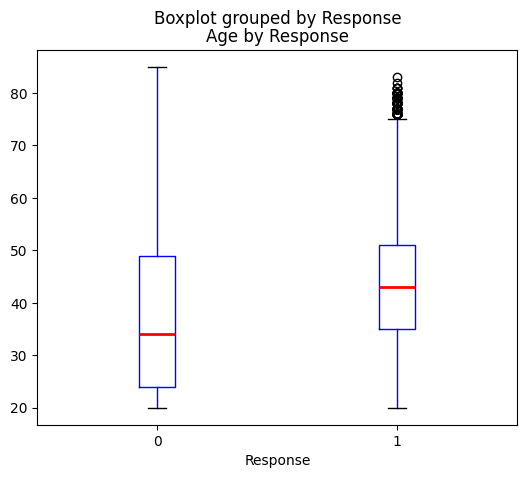

In [8]:
boxplt = df.boxplot(column='Age', by='Response', figsize=(6, 5), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) )
plt.title('Age by Response')
chi_squared_test(df, "Age", "Response")


For variable vintage instead, we can see tha the median vintage of the customers who are interested in the insurance, is equal to the median vintage of the customers who are not interested in the insurance. The p-value of the chi-squared test is 0.89 which is higher than 0.05, so we can not reject the null hypothesis of indipendece and conclude that the variable vintage is not statistically significant.

Chi2: 260.32, p-value: 0.89
Features Vintage and Response are independent
Median value for "Vintage" with Response = 0: 154.00
Median value for "Vintage" with Response = 1: 154.00


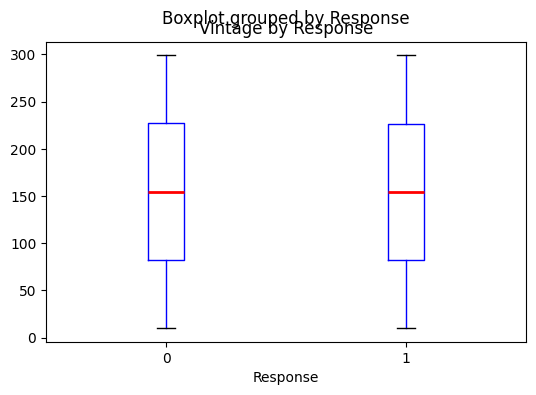

In [9]:
boxplt = df.boxplot(column='Vintage', by='Response', figsize=(6,4), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2) ) # medianprops=dict(color="red", linewidth=2), 
plt.title('Vintage by Response')
chi_squared_test(df, "Vintage", "Response")
print("Median value for \"Vintage\" with Response = 0: %.02f" % df['Vintage'].where(df['Response'] == 0).median())
print("Median value for \"Vintage\" with Response = 1: %.02f" % df['Vintage'].where(df['Response'] == 1).median())


Finally for the variable annual premium, we can see that the median annual premium of the customers who are interested in the insurance is higher (33002€ against 31504€) than the median annual premium of the customers who are not interested in the insurance, with a large presence of outlayers. The p-value of the chi-squared test is less than 0.05, so we can reject the null hypothesis of indipendece and conclude that the variable annual premium is statistically significant.

Chi2: 52395.57, p-value: 0.00
Features Annual_Premium and Response are dependent
Median value for "Annual_Premium" with Response = 0: 31504.00
Median value for "Annual_Premium" with Response = 1: 33002.00


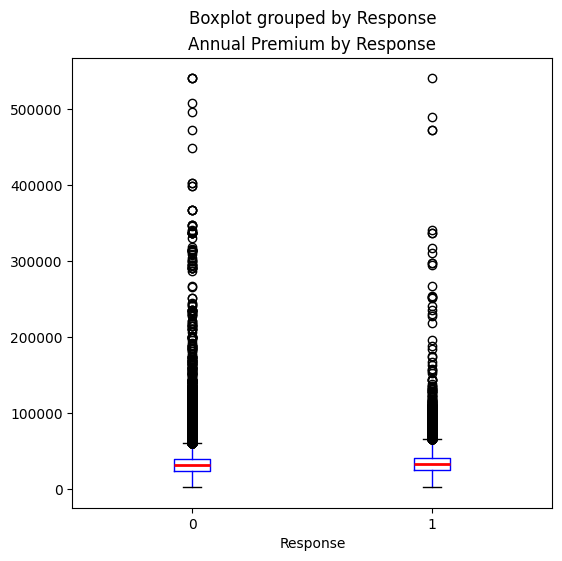

In [10]:
boxplt = df.boxplot(column='Annual_Premium', by='Response', figsize=(6,6), grid=False, color=dict(boxes='blue', whiskers='blue', caps='black'),medianprops=dict(color='red', linewidth=2))
plt.title('Annual Premium by Response')
chi_squared_test(df, "Annual_Premium", "Response")
print("Median value for \"Annual_Premium\" with Response = 0: %.02f" % df['Annual_Premium'].where(df['Response'] == 0).median())
print("Median value for \"Annual_Premium\" with Response = 1: %.02f" % df['Annual_Premium'].where(df['Response'] == 1).median())


### Catetorical Features and target variable

Now we will analyze the relationship between the categorical features and the target variable. We will use the chi-squared test. Moreover to support our analysis we will use the barplot of the categorical features and the target variable.
First of all we observe how categorical features are distributed.

In [11]:
df_categorical = insurance_df.drop(["Annual_Premium", "Age", "Vintage", "Response"],  axis=1).copy()
for column in df_categorical.columns:
    print(df_categorical[column].value_counts())
print("-------------------")
print(df["Response"].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64
Previously_Insured
0    206481
1  

As we can see, the dataset is imbalanced as the number of observations for 'Response' = 1 is 46710 and for 'Response' = 0 is 334399, and other categorical features are also imbalanced: 
* 'Vehicle_Age' has **164786** observations for *'< 1 Year'* and **200316** observations for *'1-2 Years'* and **16007** for *'> 2 Years'* variable; <br>
* 'Policy_Sales_Channel' has **134784** observations for code *152*, while many other observations has just **1** sample; <br>
* 'Region_Code' has **106415** observations for code *28*, while *51*, for example, is in just **183** samples. <br><br>

This is an important factor to consider while building the model.<br>
Moreover it is interesting to observe that the dataset has 2 features 'Policy_Sales_Channel' and 'Region_Code' which have 155 and 53 unique values respectively. This is a large number of unique values for categorical features and would be another challenging point while building the model.<br>
There are 812 buyers who have not a driving license, and surprisingly 41 of them are interested in the vehicle insurance.

In [12]:
responce_with_no_licence = insurance_df[insurance_df["Driving_License"] == 0]["Response"]
print(responce_with_no_licence.value_counts())


Response
0    771
1     41
Name: count, dtype: int64


In [13]:
def show_precentage(plot, crosstab):
     for p in plot.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height/crosstab.sum(axis=1) * 100
        if percentage.iloc[0] > 1.5:
                plot.text(x + width/2, y + height/2, f"{percentage.iloc[0]:.2f}%",
                        horizontalalignment='center', verticalalignment='center',
                        color='black')
    

Chi2: 1047.71, p-value: 0.00
Features Gender and Response are dependent
Most frequent value for Gender with Response = 0: Male
Most frequent value for Gender with Response = 1: Male


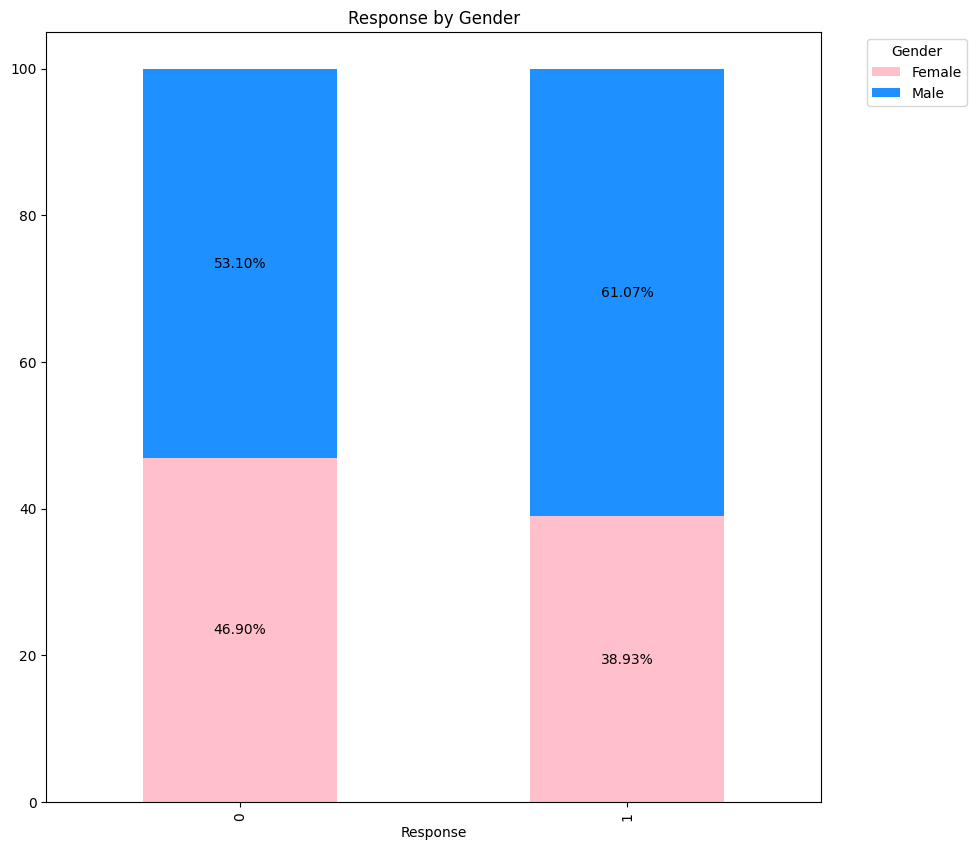

----------------------------------------------------------------------
Chi2: 38.63, p-value: 0.00
Features Driving_License and Response are dependent
Most frequent value for Driving_License with Response = 0: 1.0
Most frequent value for Driving_License with Response = 1: 1.0


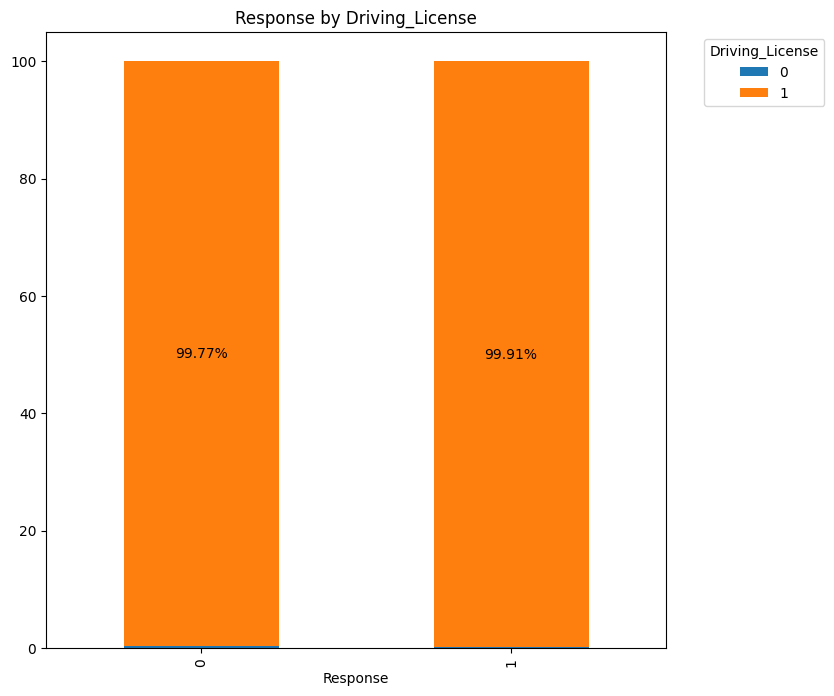

----------------------------------------------------------------------
Chi2: 7267.84, p-value: 0.00
Features Region_Code and Response are dependent
Most frequent value for Region_Code with Response = 0: 28.0
Most frequent value for Region_Code with Response = 1: 28.0


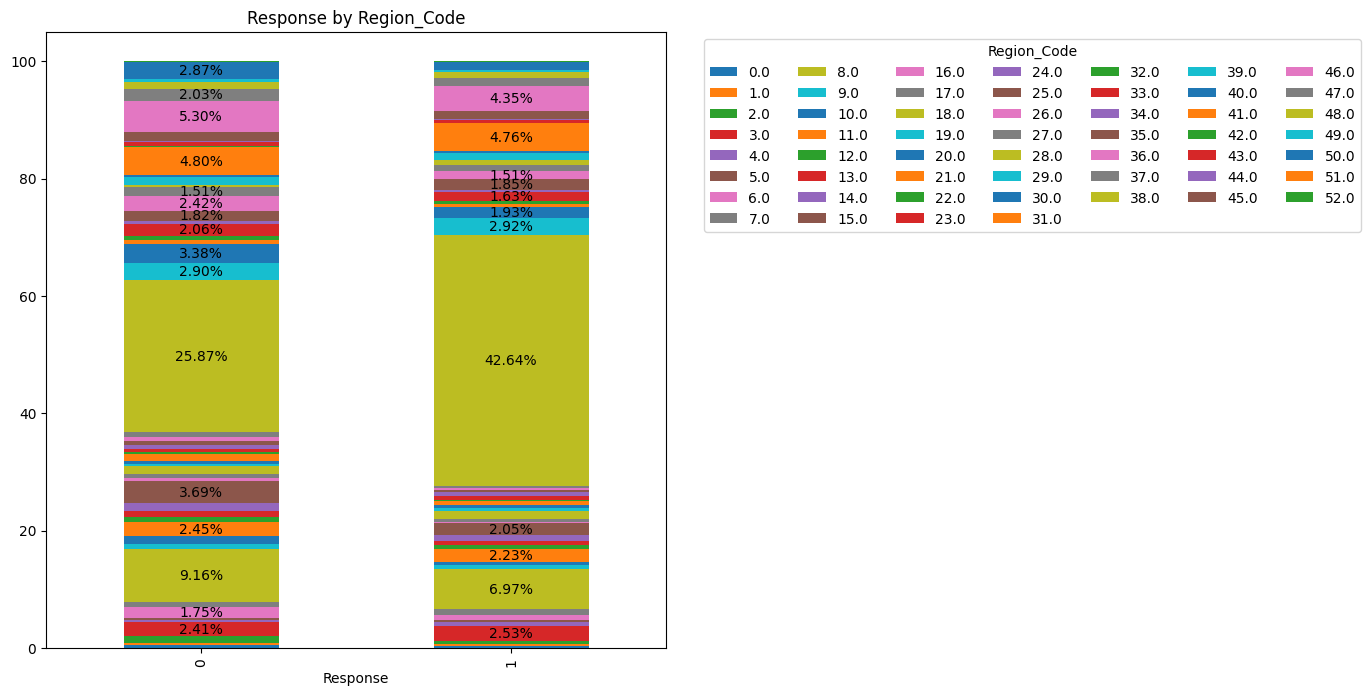

----------------------------------------------------------------------
Chi2: 44357.96, p-value: 0.00
Features Previously_Insured and Response are dependent
Most frequent value for Previously_Insured with Response = 0: 1.0
Most frequent value for Previously_Insured with Response = 1: 0.0


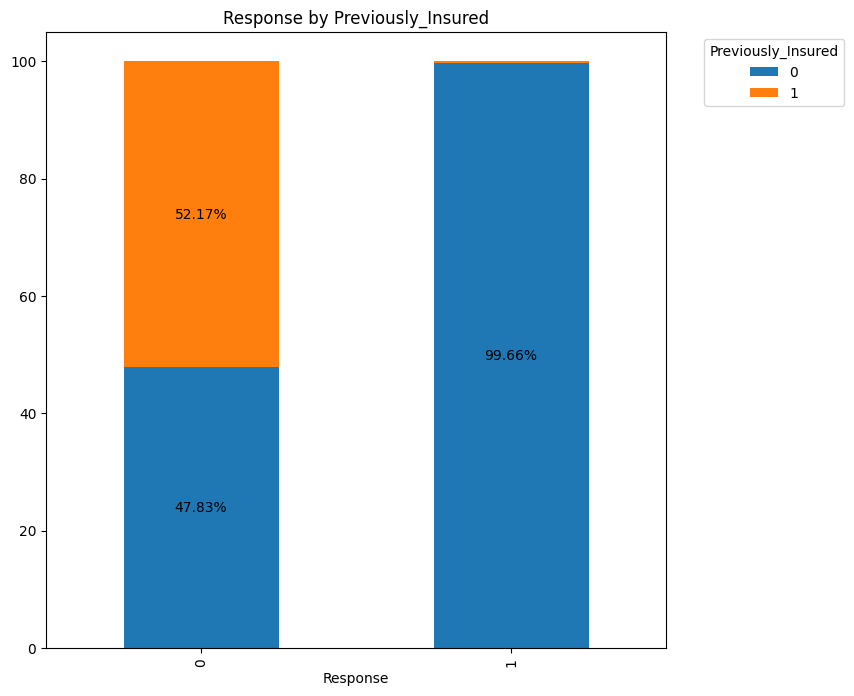

----------------------------------------------------------------------
Chi2: 18771.89, p-value: 0.00
Features Vehicle_Age and Response are dependent
Most frequent value for Vehicle_Age with Response = 0: 1-2 Year
Most frequent value for Vehicle_Age with Response = 1: 1-2 Year


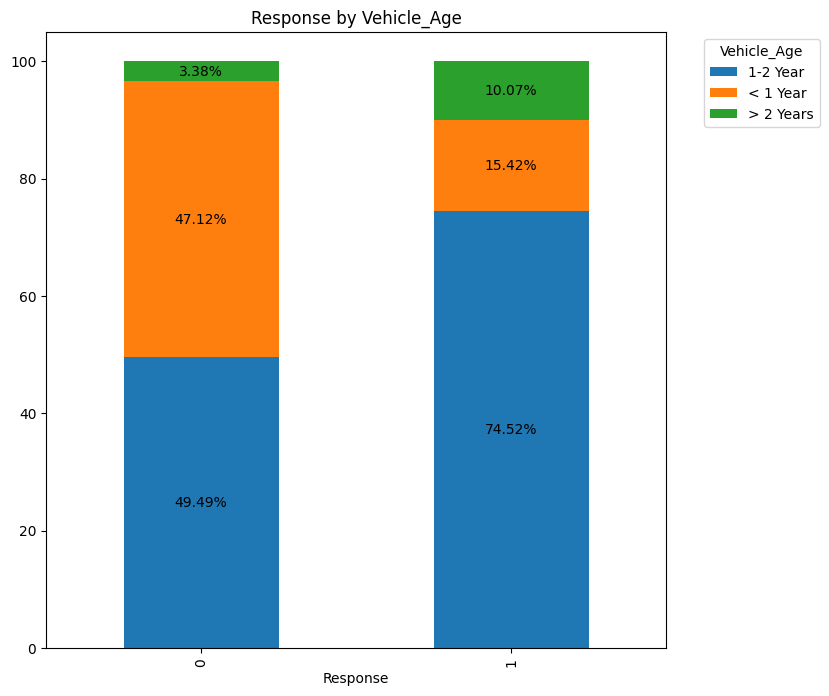

----------------------------------------------------------------------
Chi2: 47864.76, p-value: 0.00
Features Vehicle_Damage and Response are dependent
Most frequent value for Vehicle_Damage with Response = 0: No
Most frequent value for Vehicle_Damage with Response = 1: Yes


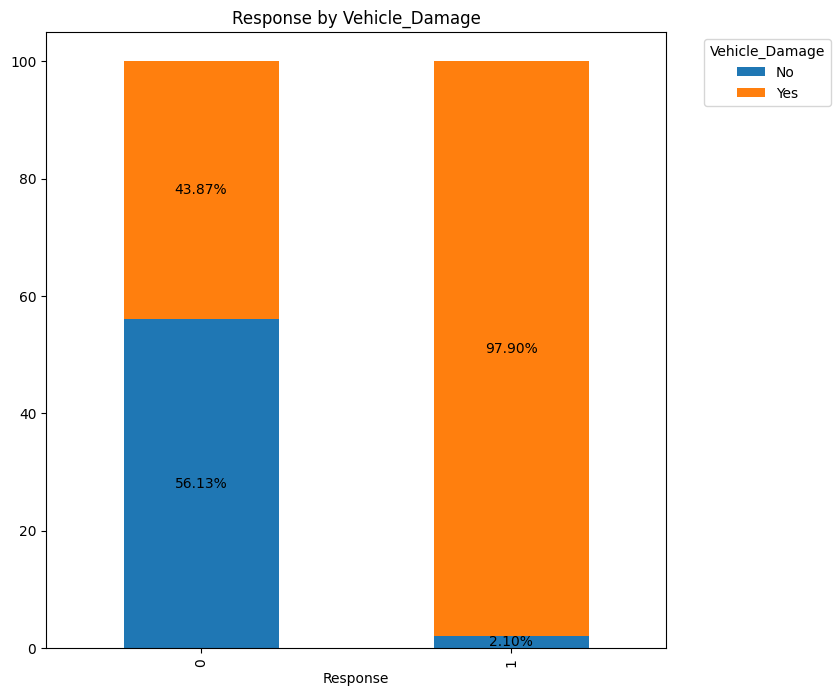

----------------------------------------------------------------------
Chi2: 26447.03, p-value: 0.00
Features Policy_Sales_Channel and Response are dependent
Most frequent value for Policy_Sales_Channel with Response = 0: 152.0
Most frequent value for Policy_Sales_Channel with Response = 1: 26.0


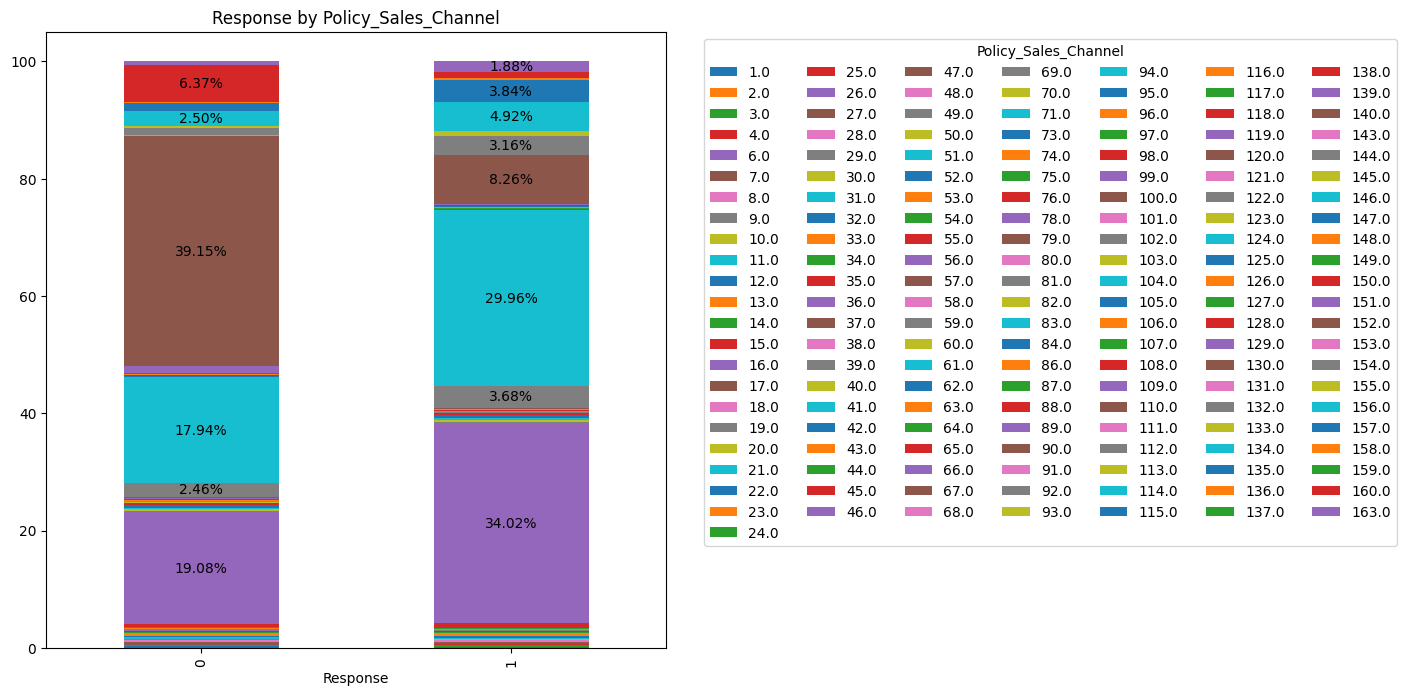

----------------------------------------------------------------------


In [14]:
for column in df_categorical.columns:
    chi_squared_test(df, column, "Response")
    print("Most frequent value for", column, "with Response = 0:", df[column].where(df['Response'] == 0).value_counts().idxmax())
    print("Most frequent value for", column, "with Response = 1:", df[column].where(df['Response'] == 1).value_counts().idxmax())
    crosstab = pd.crosstab(df["Response"], df_categorical[column])

    crosstab = crosstab.div(crosstab.sum(axis=1), axis=0)*100
    if(column != "Gender"):
        cross_plot = crosstab.plot(kind="bar", stacked=True, grid=False, figsize=(8, 8))
    else:
        cross_plot = crosstab.plot(kind="bar", stacked=True, color = ["pink", "dodgerblue"], grid=False, figsize=(10, 10))    
    plt.title(f"Response by {column}")
    if column == "Policy_Sales_Channel" or column == "Region_Code":
        plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=7)
    else:
        plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    show_precentage(cross_plot, crosstab)
    plt.show()
    print("----------------------------------------------------------------------")
    

As we can see, all the categorical variables are statistically significant, as the p-value of the chi-squared test is less than 0.05. Later we will see the correlation matrix of the features and the target variable, to determine the most important features.
From the analysis, we can conclude that, even if the dataset have not missing values, it is imbalanced and has a large number of unique values for categorical features, requiring a careful preprocessing and model building. Moreover variable "Vintange" is not statistically significant, and we still have to consider the correlation between features.

# Data Preprocessing

In [15]:
def encode_set(dataset, columns, encoder=None, show_categories=False):
    if encoder is None:
        raise ValueError("At least one of the encoders LabelEncoder() and OneHotEncoder() must be provided.")

    for column in columns:
        if type(encoder) == type(LabelEncoder()):
            dataset[column] = encoder.fit_transform(df[column])
            if show_categories:   
                print(f"Categorical feature: {column}, Number of categories: {dataset[column].nunique()}")
                
        elif type(encoder) == type(OneHotEncoder()):
            X_sparse = encoder.fit_transform(dataset[column].values.reshape(-1,1)).toarray()
            X_sparse_df =  pd.DataFrame(X_sparse, columns = [column+str(i) for i in range(X_sparse.shape[1])])
            X_sparse_df.index = dataset.index
            dataset = pd.concat([X_sparse_df, dataset], axis=1)
            dataset = dataset.drop(column, axis=1)
    
    if type(encoder) == type(OneHotEncoder()) and show_categories:
        for col in dataset.columns:
            print(f"Categorical feature: {col}, Number of categories: {dataset[col].nunique()}")   
        
    return dataset


In [16]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder() 


For a good model building, we need to preprocess the data. We will start by encoding the categorical features, then we will scale the numerical features. We will also deal with the imbalanced dataset by using and comparing 2 techniques: a mixture of random oversampling and random undersampling (taking a cue from [How to Combine Oversampling and Undersampling for Imbalanced Classification](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)) and then SMOTE (Synthetic Minority Over-sampling Technique) combined to random undersampling technique. We will also split the dataset into training and testing sets, and later, we will try a model exploiting the cross-validation technique. <br>
First we use the LabelEncoder to encode the categorical features. We can see that "Region Code" and "Policy Sales Channel" have respectively 53 and 155 unique values.

In [17]:
df_categorical = encode_set(df_categorical, encoder=label_encoder, show_categories=True, columns=df_categorical.columns)
df_categorical.head()

Categorical feature: Gender, Number of categories: 2
Categorical feature: Driving_License, Number of categories: 2
Categorical feature: Region_Code, Number of categories: 53
Categorical feature: Previously_Insured, Number of categories: 2
Categorical feature: Vehicle_Age, Number of categories: 3
Categorical feature: Vehicle_Damage, Number of categories: 2
Categorical feature: Policy_Sales_Channel, Number of categories: 155


,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
id,,,,,,,
1,1,1,28,0,2,1,24
2,1,1,3,0,0,0,24
3,1,1,28,0,2,1,24
4,1,1,11,1,1,0,145
5,0,1,41,1,1,0,145


In [18]:
df = pd.concat([df_numerical, df_categorical, insurance_df["Response"]], axis=1)

Now that we have encoded the categortical features, we can observe the correlation matrix of the features and the target variable. We can see that the most important features are "Previously_Insured", and "Vehicle_Damage", then "Policy_Sales_Channel" and "Age". We can also see that the correlation between the features is not high, except for the correlation between "Previously_Insured" and "Vehicle_Damage" which is -0.82. 
As observed in the analysis of numerical features, we can see that the variable "Vintage" is not statistically significant, and we can also see that it has a low correlation with the target variable. We will drop this variable from the dataset.

<Axes: >

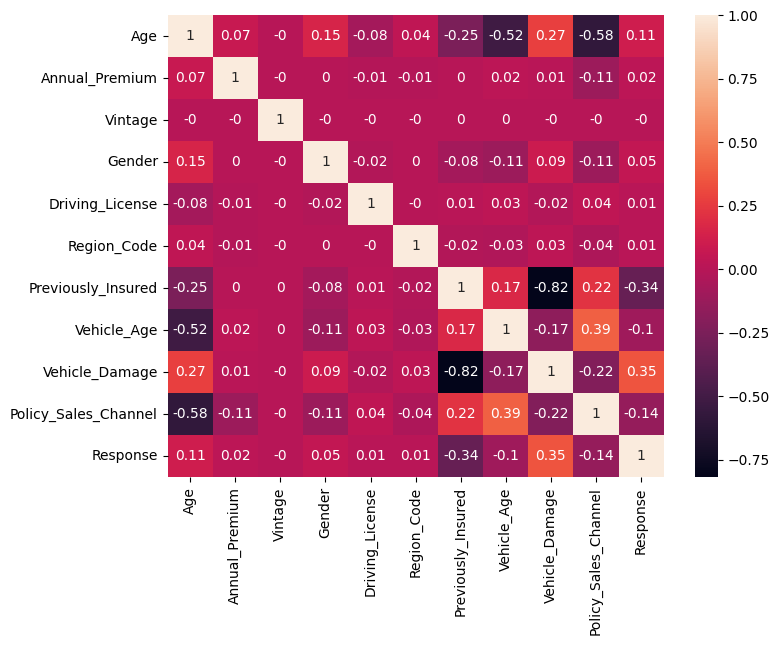

In [19]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [20]:
#df["Age"].value_counts().where(lambda x : x < 4000).dropna()
#tmp_df = pd.DataFrame(df["Age"])
#
#tmp_df.loc[tmp_df['Age']<=25, 'Age_Class'] = '1'
#tmp_df.loc[tmp_df['Age'].between(25,34), 'Age_Class'] = '2'
#tmp_df.loc[tmp_df['Age'].between(35,44), 'Age_Class'] = '3'
#tmp_df.loc[tmp_df['Age'].between(45,54), 'Age_Class'] = '4'
#tmp_df.loc[tmp_df['Age']>=55, 'Age_Class'] = '5'
#
#tmp_df = tmp_df.drop(["Age"], axis=1)
#df = pd.concat([tmp_df, df], axis=1)
#df = df.drop(["Age"], axis=1)
#df.head()
#df["Age_Class"].value_counts()

In [21]:
df = df.drop(["Vintage"], axis=1)

After that, we manage "Policy_Sales_Channel" and "Region_Code" features. To reduce the number of unique values, we set a threshold, under which we will consider the value as -1 (since we already apply label encoder). We will set the threshold to 0.02, for "Policy_Sales_Channel" and 0.025 for "Region_Code", in order to reduce the number of unique values to 10 and 9 unique values respectively.

In [22]:
def set_N_unique_features(df, columns, threshold):
    '''
    Set the top N unique values for the categorical features
    :param df: DataFrame
    :param columns: list of columns to be processed
    :param threshold: the threshold for the top N unique values
    :return: DataFrame
    '''
    for col in columns:
        if col not in df.columns:
            print(f"Column {col} does not exist in the dataframe")
            continue 

        col_name = col + "_top_N"
        channel_counts = df[col].value_counts()
        valid_channels = channel_counts[channel_counts >= threshold].index

        tmp_df = pd.DataFrame(df[col]).copy()
        tmp_df.loc[~tmp_df[col].isin(valid_channels), col_name] = -1
        tmp_df.loc[tmp_df[col].isin(valid_channels), col_name] = tmp_df[col]

        print(tmp_df[col_name].value_counts())
        df = pd.concat([tmp_df, df], axis=1)
        df = df.drop([col], axis=1)
    return df


In [23]:
threshold = round(df.shape[0] * 0.02)
df = set_N_unique_features(df, ["Policy_Sales_Channel"], threshold)

threshold = round(df.shape[0] * 0.025)
df = set_N_unique_features(df, ["Region_Code"], threshold)


Policy_Sales_Channel_top_N
 145.0    134784
 24.0      79700
 119.0     73995
-1.0       50260
 153.0     21779
 149.0     10661
 117.0      9930
Name: count, dtype: int64
Region_Code_top_N
-1.0     155998
 28.0    106415
 8.0      33877
 46.0     19749
 41.0     18263
 15.0     13308
 30.0     12191
 29.0     11065
 50.0     10243
Name: count, dtype: int64


Due to the strong correlation between "Previously_Insured" and "Vehicle_Damage", we will drop the "Vehicle_Damage" feature. Even if it has a stronger correlation with the target variable, we decided to remove "Vehicle_Damage", since "Previously_Insured" is the unique features that has a negative correlation with the target variable.
Moreover we apply the One Hot Encoding to *Policy_Sales_Channel_top_N* and *Region_Code_top_N*, and we scale the numerical features using the StandardScaler.

In [24]:
df = df.drop(["Vehicle_Damage"],axis=1).copy()
RANDOM_SEED = 10
std_scaler = StandardScaler()

X = df.drop("Response", axis=1)
X = encode_set(X, columns=["Policy_Sales_Channel_top_N", "Region_Code_top_N"], encoder=one_hot_encoder)
X["Annual_Premium"] = std_scaler.fit_transform(X["Annual_Premium"].values.reshape(-1,1))
X["Age"] = std_scaler.fit_transform(X["Age"].values.reshape(-1,1))

Y = df["Response"]

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_SEED)

m_training = X_training.shape[0]
m_test = X_test.shape[0]


### Random Oversampling and Random Undersampling Dataset

In [25]:
np.random.seed(RANDOM_SEED)

df_over_under_sampling = pd.concat([X_training, Y_training], axis=1)

idx = df_over_under_sampling[df_over_under_sampling['Response'] == 0].index

idx_to_remove = np.random.choice(idx, int(len(idx)*0.75), replace=False)
df_over_under_sampling = df_over_under_sampling.drop(idx_to_remove)

df_over_under_sampling.index = range(len(df_over_under_sampling))

idx = df_over_under_sampling[df_over_under_sampling['Response'] == 1].index
idx_to_add = np.random.choice(idx, int(len(idx)*0.80), replace=False)
samples_to_add = df_over_under_sampling.iloc[idx_to_add.tolist()]

df_over_under_sampling = pd.concat([df_over_under_sampling, samples_to_add], ignore_index=True)
print(df_over_under_sampling['Response'].value_counts())
df_over_under_sampling.head()   

Response
1    63113
0    62692
Name: count, dtype: int64


,Region_Code_top_N0,Region_Code_top_N1,Region_Code_top_N2,Region_Code_top_N3,Region_Code_top_N4,Region_Code_top_N5,Region_Code_top_N6,Region_Code_top_N7,Region_Code_top_N8,Policy_Sales_Channel_top_N0,...,Policy_Sales_Channel_top_N4,Policy_Sales_Channel_top_N5,Policy_Sales_Channel_top_N6,Age,Annual_Premium,Gender,Driving_License,Previously_Insured,Vehicle_Age,Response
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.084517,-1.622853,0,1,1,1,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.439838,0.002417,0,1,0,0,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.020049,-1.622853,0,1,1,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.785053,-1.622853,0,1,0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.697709,-0.117956,0,1,0,1,1


### SMOTE and Random Undersampling Dataset

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(sampling_strategy=0.3, random_state=RANDOM_SEED)
X_smote, Y_smote = smote.fit_resample(X_training, Y_training)
under = RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_SEED)
X_smote, Y_smote = under.fit_resample(X_smote, Y_smote)

print(Y_smote.value_counts())
X_smote.head()

Response
0    75230
1    75230
Name: count, dtype: int64


,Region_Code_top_N0,Region_Code_top_N1,Region_Code_top_N2,Region_Code_top_N3,Region_Code_top_N4,Region_Code_top_N5,Region_Code_top_N6,Region_Code_top_N7,Region_Code_top_N8,Policy_Sales_Channel_top_N0,...,Policy_Sales_Channel_top_N3,Policy_Sales_Channel_top_N4,Policy_Sales_Channel_top_N5,Policy_Sales_Channel_top_N6,Age,Annual_Premium,Gender,Driving_License,Previously_Insured,Vehicle_Age
179327,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-1.148985,0.211095,1,1,0,1
42109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.204841,-1.622853,0,1,1,0
284056,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.213453,0.359064,1,1,1,1
89770,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.267815,-1.622853,1,1,1,0
280377,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.213453,-0.086875,1,1,0,2


## Model Building

In [27]:
def evaluate_model(model, data, scaler=None, train_test_dataset='Train', print_report=False, threshold=0.5):
    '''
    Evaluate model performance on a given dataset. To be used after training the model.
    :param model: trained model
    :param data: tuple of features and labels
    :param scaler: scaler used to scale the features
    :param train_test_dataset: string to identify the dataset
    :param print_report: boolean to print classification report 
    :return: predicted labels and predicted probabilities
    '''
    X_, y_ = data
    if scaler is not None:
        X_ = scaler.transform(X_)

    y_pred_ = model.predict(X_)
    y_pred_proba_ = model.predict_proba(X_)

    if threshold != 0.5:
        y_pred_ = np.where(y_pred_proba_[:,1] > threshold, 1, 0)


    print('Accuracy: {:.3f}'.format(model.score(X_, y_)))
    print(f"Log-Loss: {log_loss(y_, y_pred_proba_):.3f}")
    if print_report:
        print(f"{train_test_dataset} Report:")
        print(classification_report(y_, y_pred_, digits=4))

    return y_pred_, y_pred_proba_

def random_split_train_test_set(X, Y, test_size=0.20, random_state=42):
    '''
    Split the dataset into training and test sets
    :param X: features
    :param Y: labels
    :param test_size: fraction of the dataset to be used as test set
    :param random_state: random seed
    :return: training and test sets for features and labels
    '''
    m = X.shape[0]
    m_train = int(m * (1-test_size))
    m_test = m - m_train

    
    random_indices = np.random.permutation(m)
    X_rand = X[random_indices]
    Y_rand = Y[random_indices]

    X_training, X_test, Y_training, Y_test = train_test_split(X_rand, Y_rand, test_size =float(m_test)/float(m), random_state=random_state)

    #let's see what the fraction of ones in the entire dataset is
    print("Fraction of ones in the train set: ", round(float(sum(Y_training))/float(m_train), 3))
    print("Fraction of ones in the test set: ", round(float(sum(Y_test))/float(m_test), 3))
    print("Fraction of ones in the entire dataset: ", round(float(sum(Y_training)+sum(Y_test))/float(m_train+m_test), 3))

    return X_training, X_test, Y_training, Y_test

def plot_confusion_matrix(confusion_matrix, title):
    '''
    Plot the confusion matrix
    :param confusion_matrix: confusion matrix
    :param title: title of the plot
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(data=confusion_matrix, annot=True, fmt='g')
    plt.title(title, fontdict={'verticalalignment': 'baseline'})
    plt.text(0, 2.2, f"Precision: {(confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])):.3f}") 
    plt.text(1, 2.2, f"Recall: {(confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])):.3f}") 
    ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
    ax.yaxis.set_ticklabels(['No', 'Yes'])
    plt.show()

def plot_roc_curve(Y_test, y_pred_proba_test, multiclass=None,average=None):

    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_score = 0
    label = 'ROC curve (area = %0.2f).' % roc_auc
    if multiclass is not None and average is not None:
        auc_score = roc_auc_score(Y_test, y_pred_proba_test[:,1], multi_class=multiclass, average=average)
        label = label+' AUC score %0.2f' % auc_score
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=label)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()


### Model 1: LogisticRegression with Hold-Out and L2-regulation
#### Random Oversampling and Random Undersampling Dataset
The first model we want to train is a Logistic Regression model with L2 regulation. We decided to use the hold-out technique to split the dataset into training and testing sets (the split has been done before). 
For model evalutation, we decide to use different metrics, to have a wider perspective on model performance.

In [28]:
df_over_under_sampling.head()

,Region_Code_top_N0,Region_Code_top_N1,Region_Code_top_N2,Region_Code_top_N3,Region_Code_top_N4,Region_Code_top_N5,Region_Code_top_N6,Region_Code_top_N7,Region_Code_top_N8,Policy_Sales_Channel_top_N0,...,Policy_Sales_Channel_top_N4,Policy_Sales_Channel_top_N5,Policy_Sales_Channel_top_N6,Age,Annual_Premium,Gender,Driving_License,Previously_Insured,Vehicle_Age,Response
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.084517,-1.622853,0,1,1,1,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.439838,0.002417,0,1,0,0,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-1.020049,-1.622853,0,1,1,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.785053,-1.622853,0,1,0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.697709,-0.117956,0,1,0,1,1


In [29]:
log_reg = LogisticRegression(penalty='l2', C=0.01, solver="newton-cg", class_weight='balanced')
X_training = df_over_under_sampling.drop("Response", axis=1)
Y_training = df_over_under_sampling["Response"]
log_reg.fit(X_training, Y_training)
y_pred_train, y_pred_proba_train = evaluate_model(log_reg, (X_training, Y_training), print_report=True, threshold=0.4)

Accuracy: 0.780
Log-Loss: 0.449
Train Report:
              precision    recall  f1-score   support

           0     0.9638    0.5669    0.7139     62692
           1     0.6947    0.9789    0.8126     63113

    accuracy                         0.7736    125805
   macro avg     0.8293    0.7729    0.7633    125805
weighted avg     0.8288    0.7736    0.7634    125805



After having trained the model, we can see that the model has a quite good performance, with an accuracy of 0.78, and a log-loss of 0.45. Going more in details, we can observe that from the train report we have an optimal recall for target "Response" equal to 1, meaning that the model is able to correctly classify an interested client. That is, if a customer is really interested in taking out an insurance policy, he or she is actually classified as interested 98.68% of the time. On the other hand, the precision is quite low, meaning that the model is not able to correctly classify a non-interested client. This cause a large number of false positives. 
A consideration at this point must be made.
The company in order to not miss a potential customer, could be more interested in a model with a high recall on positive responses, than in having a precise model on negative responses, even if it means to contact a customer who is not interested in the insurance.
Let confirm the model performance testing it with the testing set.

In [30]:
y_pred_test, y_pred_proba_test = evaluate_model(log_reg, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.4)

Accuracy: 0.673
Log-Loss: 0.498
Test Report:
              precision    recall  f1-score   support

           0     0.9950    0.5618    0.7182     83631
           1     0.2375    0.9797    0.3823     11647

    accuracy                         0.6129     95278
   macro avg     0.6162    0.7708    0.5502     95278
weighted avg     0.9024    0.6129    0.6771     95278



Performance are very similar to the training set in terms of recall, with a lower accuracy and a slightly lower log-loss. The recall for target "Response" equal to 1 is still very high, but we loose lot of precision (69% against 23%).
To have a vibility of the model performance, we can plot the ROC curve and the confusion matrix.

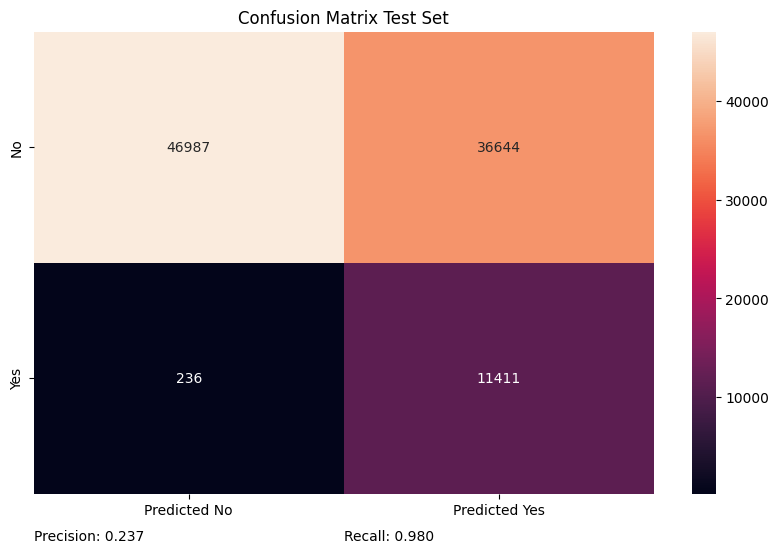

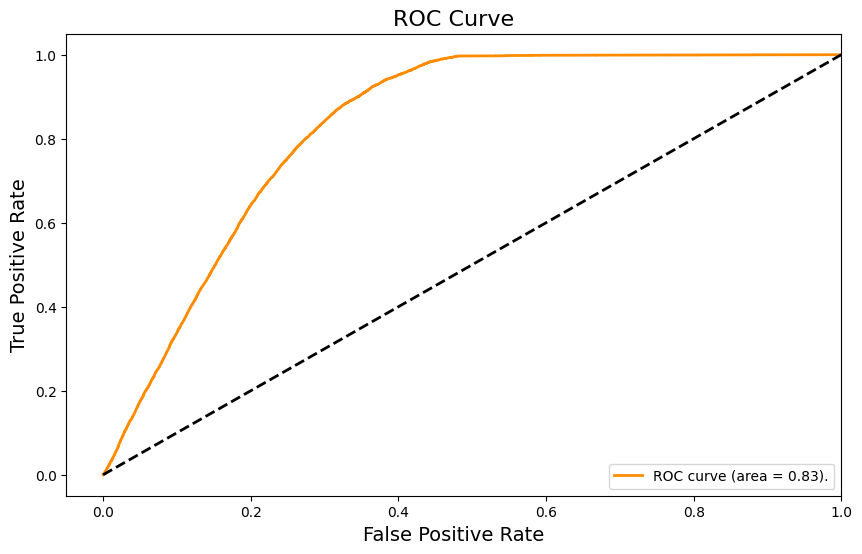

In [31]:
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

plot_roc_curve(Y_test, y_pred_proba_test)

#### Random Oversampling and Random Undersampling Dataset
We now try to train the same model structure, using the dataset rebalanced using SMOTE and Random undersampling.
For coherence we will use the same metrics as before to evaluate the model performance.

In [32]:
log_reg_smote = LogisticRegression(penalty='l2', C=0.01, solver="newton-cg", class_weight='balanced')

log_reg_smote.fit(X_smote, Y_smote)
y_pred_train, y_pred_proba_train = evaluate_model(log_reg_smote, (X_smote, Y_smote), print_report=True, threshold=0.4)

Accuracy: 0.778
Log-Loss: 0.450
Train Report:
              precision    recall  f1-score   support

           0     0.9657    0.5622    0.7107     75230
           1     0.6912    0.9800    0.8107     75230

    accuracy                         0.7711    150460
   macro avg     0.8285    0.7711    0.7607    150460
weighted avg     0.8285    0.7711    0.7607    150460



In [33]:
y_pred_test, y_pred_proba_test = evaluate_model(log_reg_smote, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.4)

Accuracy: 0.673
Log-Loss: 0.495
Test Report:
              precision    recall  f1-score   support

           0     0.9950    0.5623    0.7185     83631
           1     0.2377    0.9798    0.3825     11647

    accuracy                         0.6133     95278
   macro avg     0.6163    0.7711    0.5505     95278
weighted avg     0.9024    0.6133    0.6775     95278



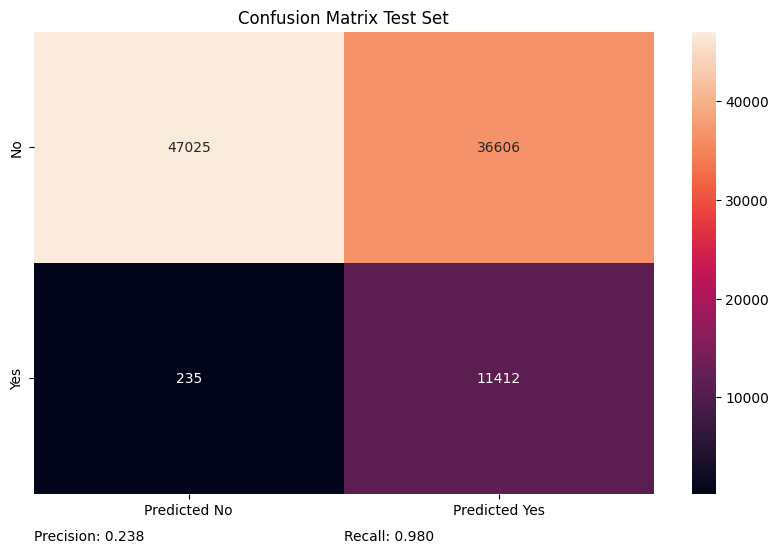

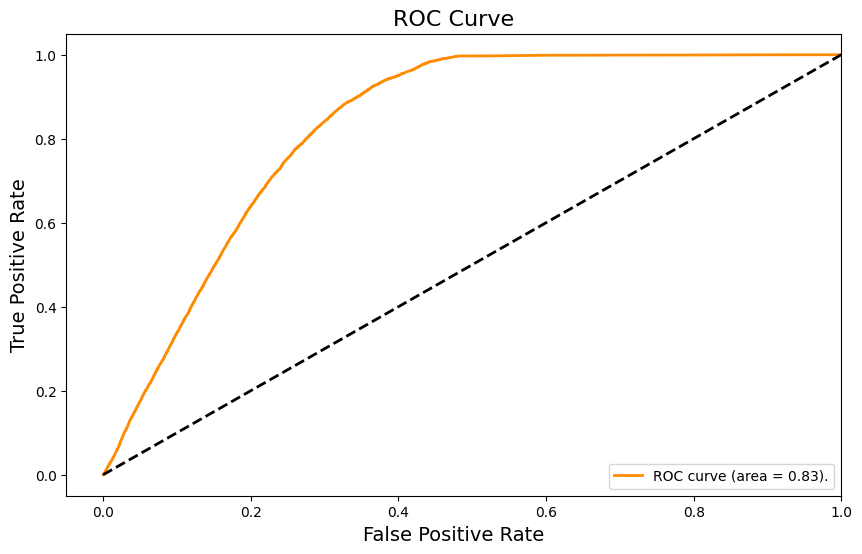

In [34]:
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

plot_roc_curve(Y_test, y_pred_proba_test)

The performance of this second model are very similar to the first one, with a slightly lower accuracy and a slightly higher log-loss, while the recall does not undergo significant changes. The precision is slightly higher, but still low.<br>

So we can conclude that the model performance is not affected by the rebalancing technique used, and the model is able to correctly classify an interested client, but not a non-interested client. We can try to improve the model performance.

### Model 2: LogisticRegression with Cross Validation and polynomial features

In [35]:
def logistic_regression_CV(X_training, Y_training, cv=10, penalty='l2', solver="lbfgs" ,class_weight='balanced'):
    log_reg_cv = LogisticRegressionCV(Cs=10, cv=cv, penalty=penalty, class_weight=class_weight, solver=solver)
    log_reg_cv.fit(X_training, Y_training)

    print("Values of parameter C tried in {}-fold Cross-Validation: {}".format(cv, log_reg_cv.Cs_ ))
    CV_accuracies = np.divide(np.sum(log_reg_cv.scores_[1],0),cv)
    print("Accuracies obtained for the different values of C with {}-fold Cross-Validation: {}".format(cv, CV_accuracies ))

    print("Best value C according to {}-fold Cross-Validation: {}".format(cv, log_reg_cv.C_[0] ))

    regL2_best_CV_accuracy = np.max(log_reg_cv.scores_[1])
    print("{}-fold Cross-Validation accuracies obtained with the best value of parameter C: {}".format(cv, regL2_best_CV_accuracy))

    regL2_full = LogisticRegression(C = log_reg_cv.C_[0], penalty=penalty, class_weight=class_weight, solver=solver)


    #fit the model using the best C on the entire training set
    regL2_full.fit(X_training, Y_training)
    evaluate_model(regL2_full, (X_training, Y_training), print_report=False)
    return regL2_full


#### Random Oversampling and Random Undersampling Dataset


<Axes: >

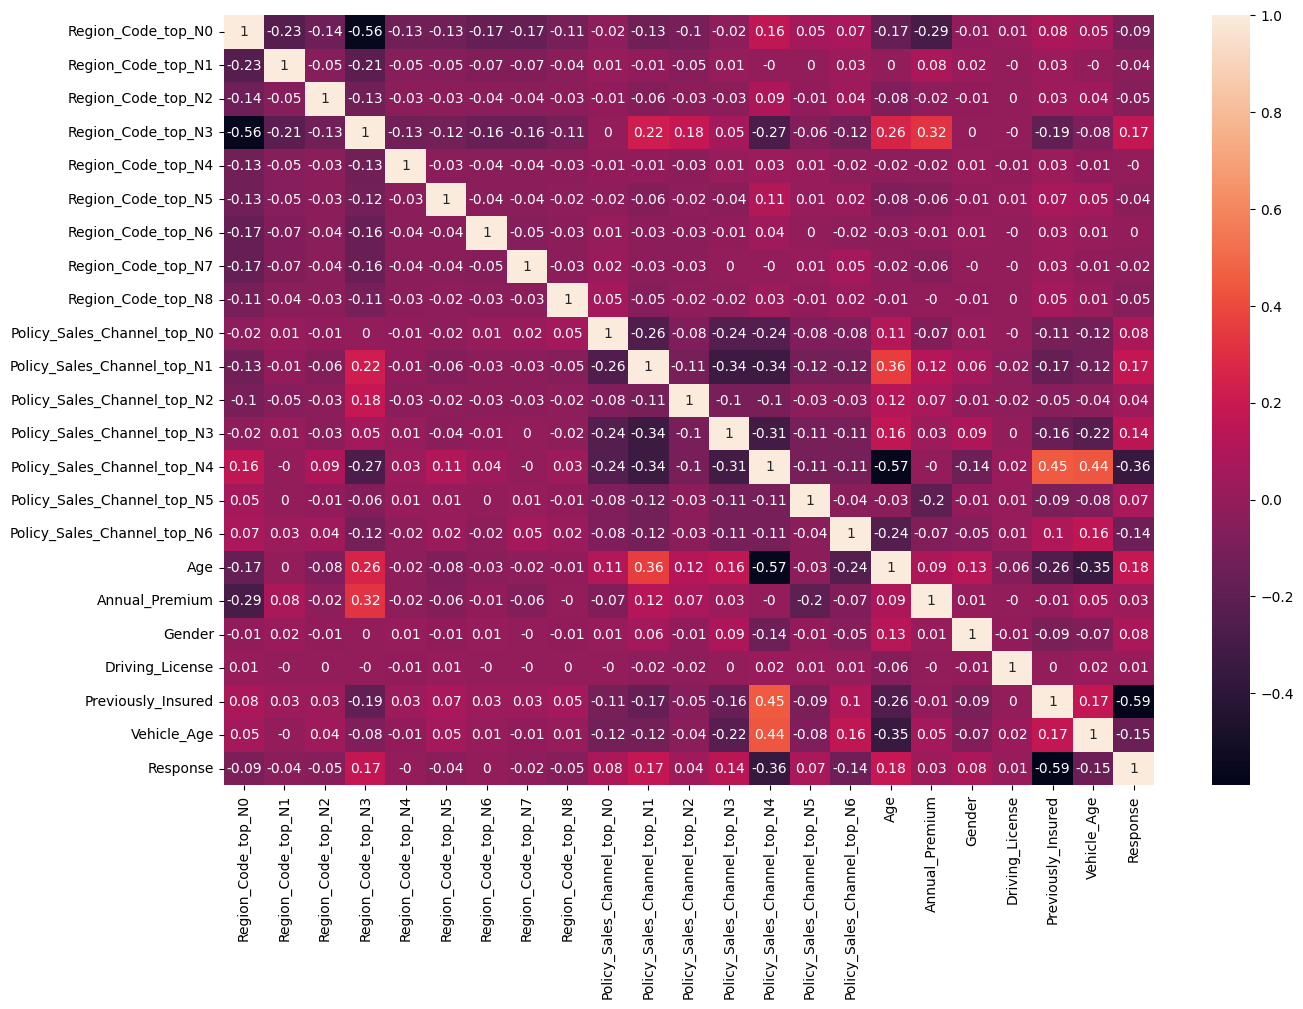

In [36]:
plt.figure(figsize=(15, 10))
corr_matrix = pd.concat([X_training, Y_training], axis=1).corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

<Axes: >

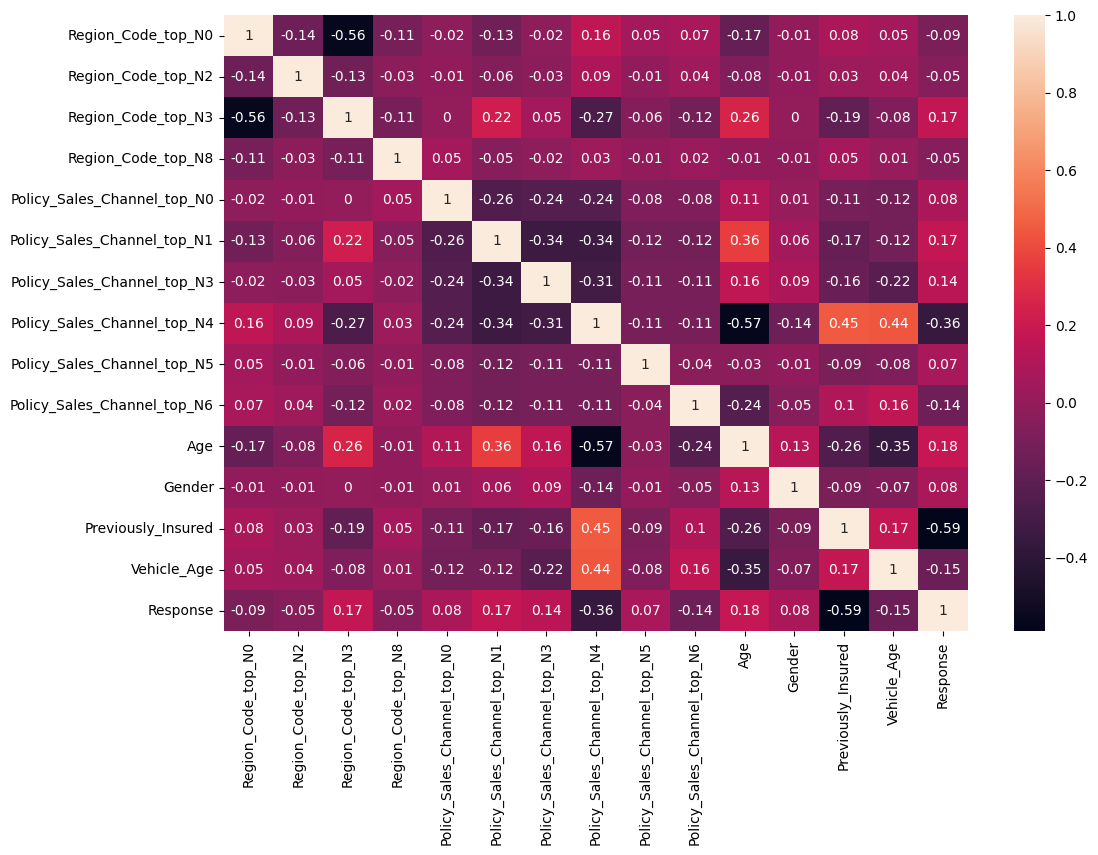

In [37]:
#X_training = X_training.drop(["Region_Code_top_N4", "Region_Code_top_N6"], axis=1)
#X_test = X_test.drop(["Region_Code_top_N4", "Region_Code_top_N6"], axis=1)
X_training = X_training.drop(["Region_Code_top_N1","Region_Code_top_N4","Region_Code_top_N5", "Region_Code_top_N6", "Region_Code_top_N7", "Policy_Sales_Channel_top_N2", "Driving_License", "Annual_Premium"], axis=1)
X_test = X_test.drop(["Region_Code_top_N1", "Region_Code_top_N4", "Region_Code_top_N5", "Region_Code_top_N6", "Region_Code_top_N7", "Policy_Sales_Channel_top_N2", "Driving_License", "Annual_Premium"], axis=1)
plt.figure(figsize=(12, 8))
corr_matrix = pd.concat([X_training, Y_training], axis=1).corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [38]:
regL2_full = logistic_regression_CV(X_training, Y_training, cv=10, penalty='l2', solver="newton-cg", class_weight='balanced')
y_pred_train, y_pred_proba_train = evaluate_model(regL2_full, (X_training, Y_training), print_report=True, threshold=0.4)
y_pred_test, y_pred_proba_test = evaluate_model(regL2_full, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.4)

Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.77698821 0.77790232 0.77888799 0.77922979 0.7791662  0.7791821
 0.7791821  0.7791821  0.7791821  0.7791821 ]
Best value C according to 10-fold Cross-Validation: 0.046415888336127774
10-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7848171701112877
Accuracy: 0.779
Log-Loss: 0.448
Accuracy: 0.779
Log-Loss: 0.448
Train Report:
              precision    recall  f1-score   support

           0     0.9654    0.5669    0.7144     62692
           1     0.6949    0.9798    0.8131     63113

    accuracy                         0.7741    125805
   macro avg     0.8302    0.7734    0.7638    125805
weighted avg     0.8297    0.7741    0.7639    125805

Accuracy: 0.673
Lo

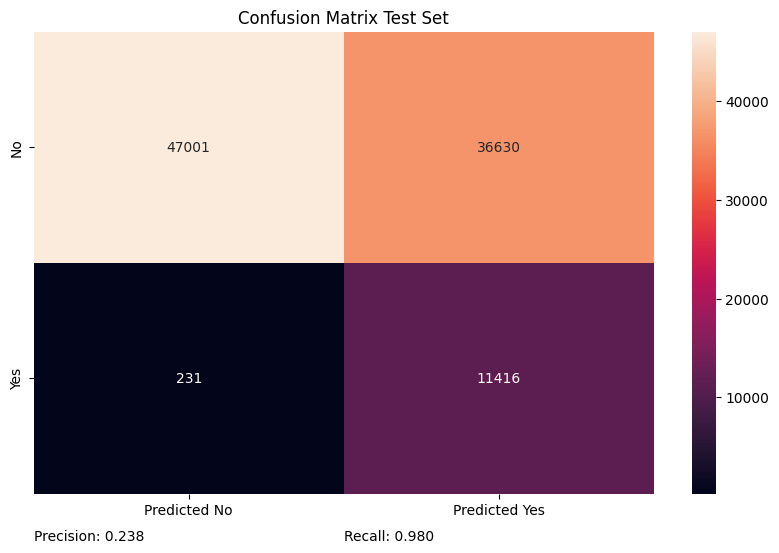

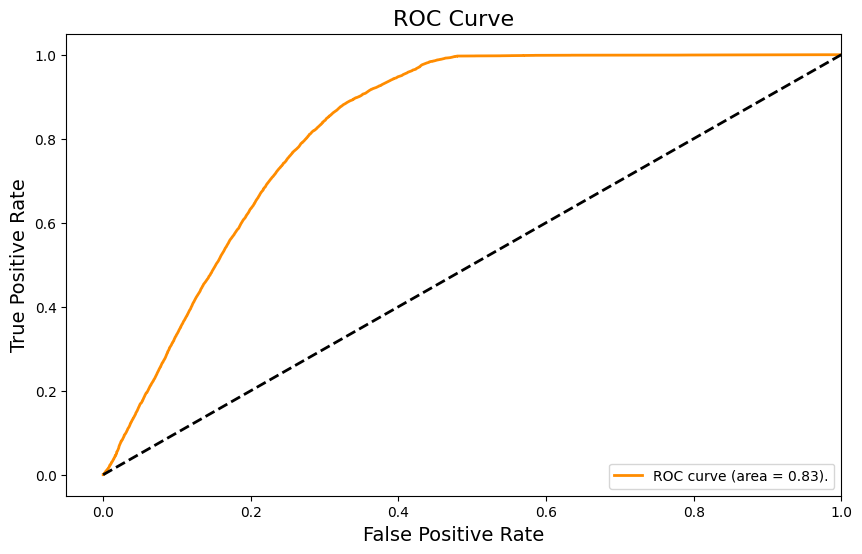

In [39]:
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

plot_roc_curve(Y_test, y_pred_proba_test)

#### Random Oversampling and Random Undersampling Dataset


<Axes: >

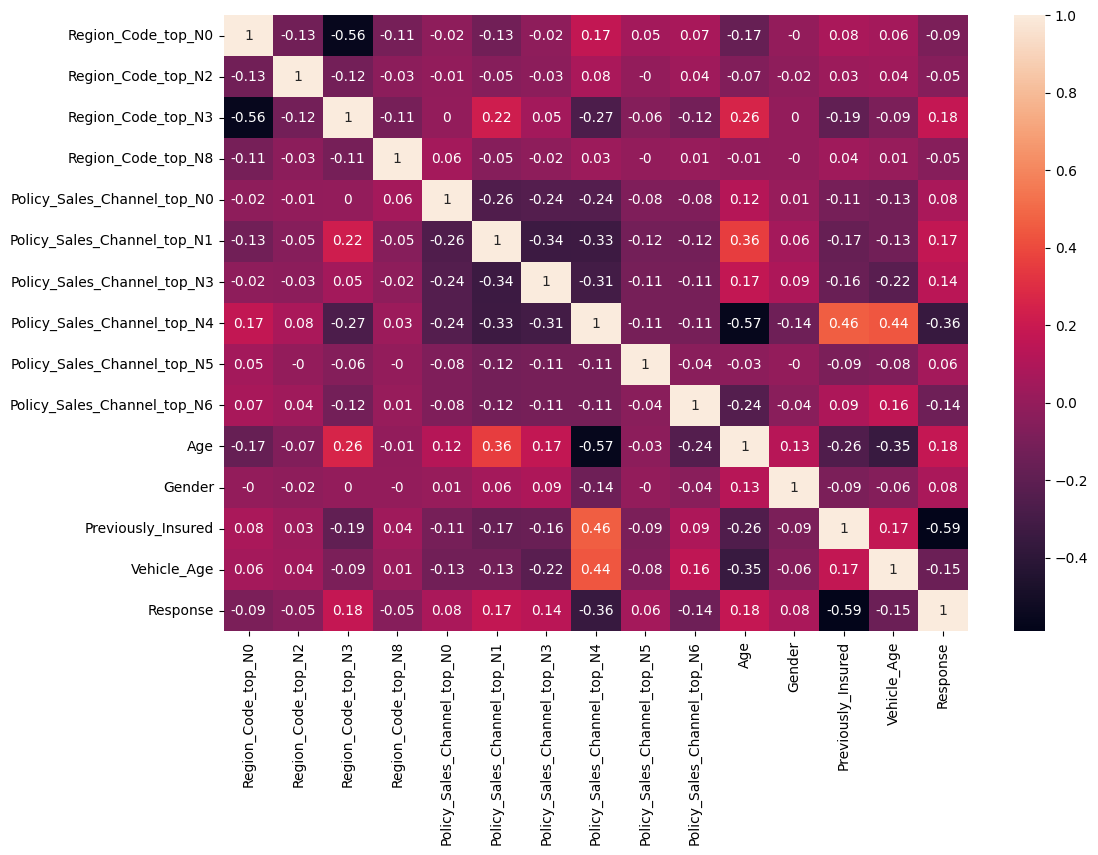

In [40]:
X_smote = X_smote.drop(["Region_Code_top_N1","Region_Code_top_N4","Region_Code_top_N5", "Region_Code_top_N6", "Region_Code_top_N7", "Policy_Sales_Channel_top_N2", "Driving_License", "Annual_Premium"], axis=1)

plt.figure(figsize=(12, 8))
corr_matrix = pd.concat([X_smote, Y_smote], axis=1).corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)


Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.77499668 0.77609331 0.77667819 0.77732288 0.77713678 0.77707696
 0.77707032 0.77707032 0.77707032 0.77707032]
Best value C according to 10-fold Cross-Validation: 0.046415888336127774
10-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7820683238069919
Accuracy: 0.777
Log-Loss: 0.449
Accuracy: 0.777
Log-Loss: 0.449
Train Report:
              precision    recall  f1-score   support

           0     0.9662    0.5619    0.7106     75230
           1     0.6912    0.9804    0.8107     75230

    accuracy                         0.7711    150460
   macro avg     0.8287    0.7711    0.7607    150460
weighted avg     0.8287    0.7711    0.7607    150460

Accuracy: 0.671
L

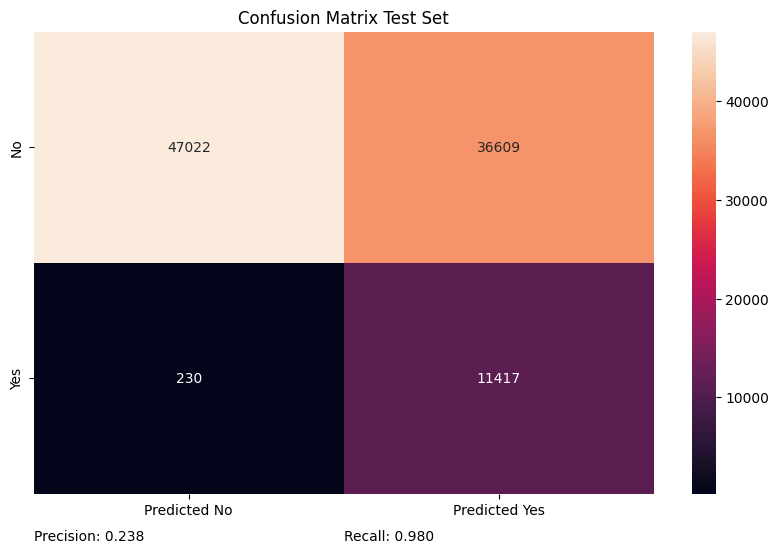

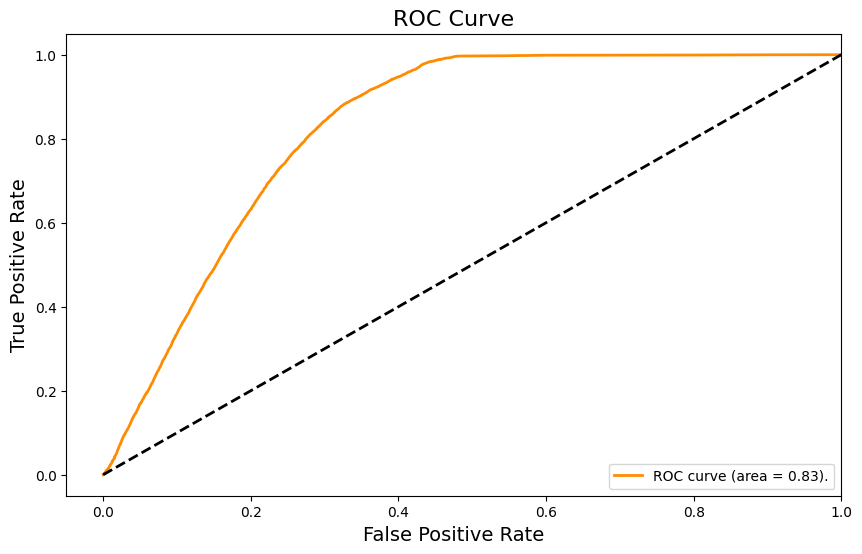

In [41]:
regL2_full = logistic_regression_CV(X_smote, Y_smote, cv=10, penalty='l2', solver="newton-cg", class_weight='balanced')

y_pred_train, y_pred_proba_train = evaluate_model(regL2_full, (X_smote, Y_smote), print_report=True, threshold=0.4)
y_pred_test, y_pred_proba_test = evaluate_model(regL2_full, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.4)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

plot_roc_curve(Y_test, y_pred_proba_test)

#### Model 3: LogisticRegression with Cross Validation: only undersampling

In [42]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_SEED)

X_training = X_training.drop(["Region_Code_top_N1","Region_Code_top_N4","Region_Code_top_N5", "Region_Code_top_N6", "Region_Code_top_N7", "Policy_Sales_Channel_top_N2", "Driving_License", "Annual_Premium"], axis=1)
X_test = X_test.drop(["Region_Code_top_N1", "Region_Code_top_N4", "Region_Code_top_N5", "Region_Code_top_N6", "Region_Code_top_N7", "Policy_Sales_Channel_top_N2", "Driving_License", "Annual_Premium"], axis=1)

under = RandomUnderSampler(sampling_strategy='auto', random_state=RANDOM_SEED)
X_train_under, Y_train_under = under.fit_resample(X_training, Y_training)

Y_train_under.value_counts()


Response
0    35063
1    35063
Name: count, dtype: int64

In [43]:
regL2_full = logistic_regression_CV(X_train_under, Y_train_under, cv=10, penalty='l2', solver="newton-cg", class_weight='balanced')

y_pred_train, y_pred_proba_train = evaluate_model(regL2_full, (X_train_under, Y_train_under), print_report=True, threshold=0.4)
y_pred_test, y_pred_proba_test = evaluate_model(regL2_full, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.4)

Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.767932   0.77393555 0.77578935 0.77621717 0.77583215 0.77573233
 0.77564678 0.77566104 0.77566104 0.77566104]
Best value C according to 10-fold Cross-Validation: 0.046415888336127774
10-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7828318836446599
Accuracy: 0.776
Log-Loss: 0.452
Accuracy: 0.776
Log-Loss: 0.452
Train Report:
              precision    recall  f1-score   support

           0     0.9648    0.5609    0.7094     35063
           1     0.6905    0.9796    0.8100     35063

    accuracy                         0.7702     70126
   macro avg     0.8277    0.7702    0.7597     70126
weighted avg     0.8277    0.7702    0.7597     70126

Accuracy: 0.673
L

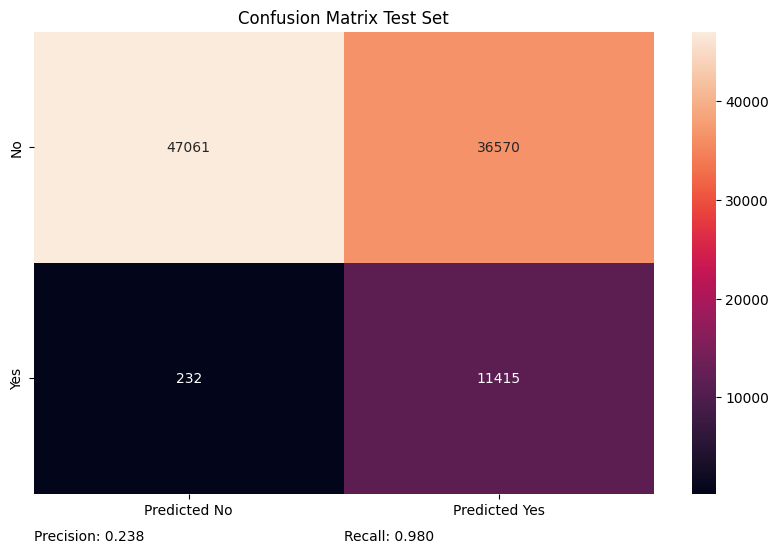

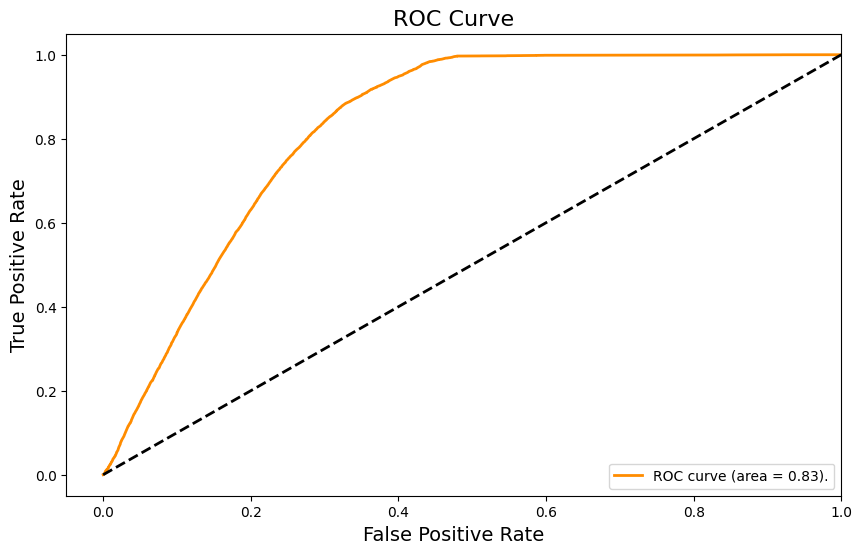

In [44]:
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

plot_roc_curve(Y_test, y_pred_proba_test)

#### Last model: StratifiedKFold with GridSearchCV and LogisticRegression


In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'solver': ['newton-cg', 'newton-cholesky' 'saga']}
log_reg = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring=['precision', 'recall'], refit='precision', verbose=1, n_jobs=-1)
grid_search.fit(X_training, Y_training)


Fitting 10 folds for each of 28 candidates, totalling 280 fits


/home/enrmic/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/enrmic/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'newton-choleskysaga']},
             refit='precision', scoring=['precision', 'recall'], verbose=1)

In [58]:
log_reg_best = grid_search.best_estimator_
y_pred_train, y_pred_proba_train = evaluate_model(log_reg_best, (X_training, Y_training), print_report=True, threshold=0.45)
y_pred_test, y_pred_proba_test = evaluate_model(log_reg_best, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.45)



Accuracy: 0.677
Log-Loss: 0.505
Train Report:
              precision    recall  f1-score   support

           0     0.9863    0.6083    0.7525    250768
           1     0.2511    0.9397    0.3964     35063

    accuracy                         0.6489    285831
   macro avg     0.6187    0.7740    0.5744    285831
weighted avg     0.8961    0.6489    0.7088    285831

Accuracy: 0.676
Log-Loss: 0.505
Test Report:
              precision    recall  f1-score   support

           0     0.9860    0.6081    0.7522     83631
           1     0.2500    0.9381    0.3948     11647

    accuracy                         0.6484     95278
   macro avg     0.6180    0.7731    0.5735     95278
weighted avg     0.8960    0.6484    0.7085     95278



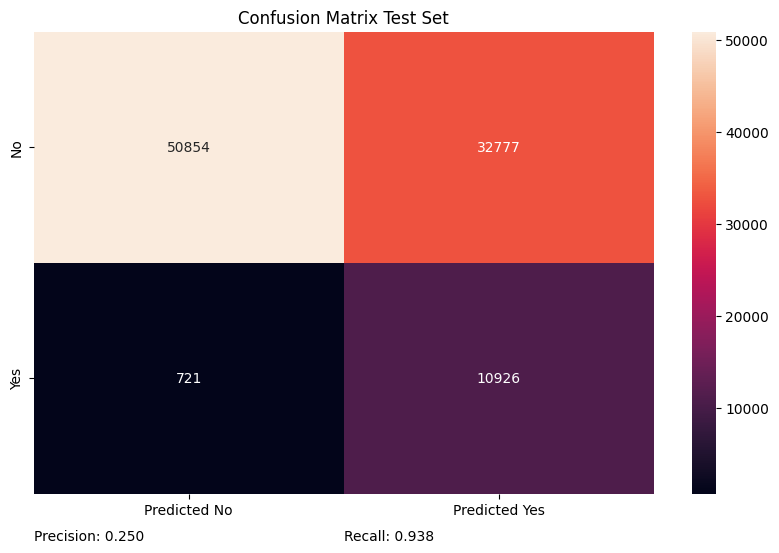

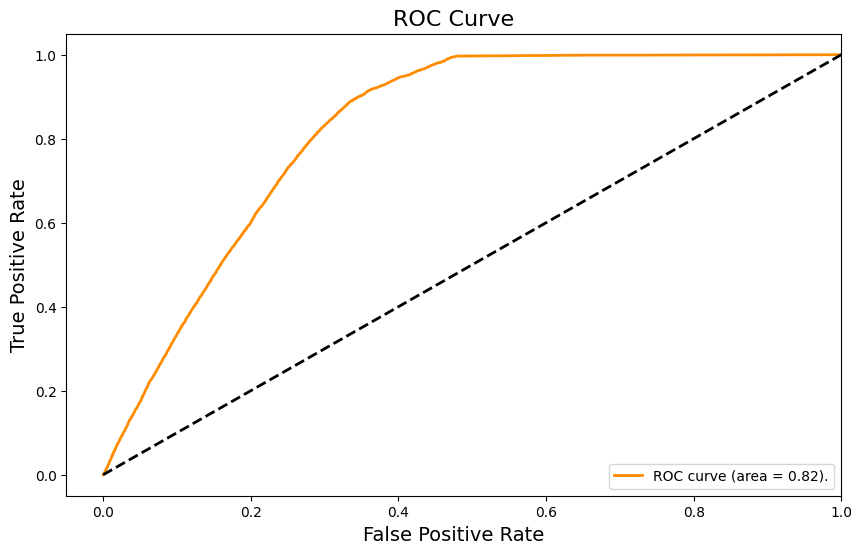

In [60]:
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

plot_roc_curve(Y_test, y_pred_proba_test)